In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [17]:
import pandas as pd

# Load the dataset
df = pd.read_csv('GenZ_DatingApp_Data.csv')

def clean_data(df):
    
    # Create a copy to avoid modifying the original data
    cleaned_df = df.copy()
    
    # Displaying number of duplicate rows
    duplicates = cleaned_df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}\n")

    # Remove duplicates
    cleaned_df = cleaned_df.drop_duplicates()

    # Display missing values per column (only those with missing values)
    missing_values = cleaned_df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  

    if not missing_values.empty:
        print("Missing values per column:")
        print(missing_values, "\n")
    else:
        print("No missing values found.\n")

    # Handle missing values
    cleaned_df = cleaned_df.assign(
        Primary_App=cleaned_df['Primary_App'].fillna('None'),
        Secondary_Apps=cleaned_df['Secondary_Apps'].fillna('None'),
        Challenges=cleaned_df['Challenges'].fillna('None') 
    )
        
    # Standardize categorical values
    cleaned_df['Gender'] = cleaned_df['Gender'].str.lower().str.strip()
    cleaned_df['Location'] = cleaned_df['Location'].str.title().str.strip()

    # Display unique values in categorical columns
    categorical_cols = cleaned_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"Unique values in {col}:")
        print(cleaned_df[col].value_counts(), "\n")

    # Detecting outliers using IQR method for numerical columns
    numerical_cols = ['Age', 'Satisfaction']
    
    for col in numerical_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Flag outliers
        cleaned_df[f'{col}_outlier'] = (cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)

    return cleaned_df

# Clean the data and display insights
cleaned_df = clean_data(df)

# Save the cleaned dataset
cleaned_df.to_csv('GenZ_DatingApp_Data_cleaned.csv', index=False)

print("Cleaned dataset saved as 'GenZ_DatingApp_Data_cleaned.csv'.")


Number of duplicate rows: 0

Missing values per column:
Primary_App       107
Secondary_Apps    114
Challenges        117
dtype: int64 

Unique values in Gender:
Gender
female        176
male          171
non-binary    153
Name: count, dtype: int64 

Unique values in Location:
Location
Mumbai       82
Delhi        76
Kolkata      76
Bangalore    69
Pune         67
Chennai      66
Hyderabad    64
Name: count, dtype: int64 

Unique values in Education:
Education
Graduate         169
Undergraduate    166
Postgraduate     165
Name: count, dtype: int64 

Unique values in Occupation:
Occupation
Student          106
Intern           105
Freelancer       103
Full-time Job    100
Part-time Job     86
Name: count, dtype: int64 

Unique values in Primary_App:
Primary_App
OkCupid    118
None       107
Hinge      106
Bumble      93
Tinder      76
Name: count, dtype: int64 

Unique values in Secondary_Apps:
Secondary_Apps
None       114
Hinge      103
OkCupid     96
Bumble      95
Tinder      92
Nam

<Figure size 1200x800 with 0 Axes>

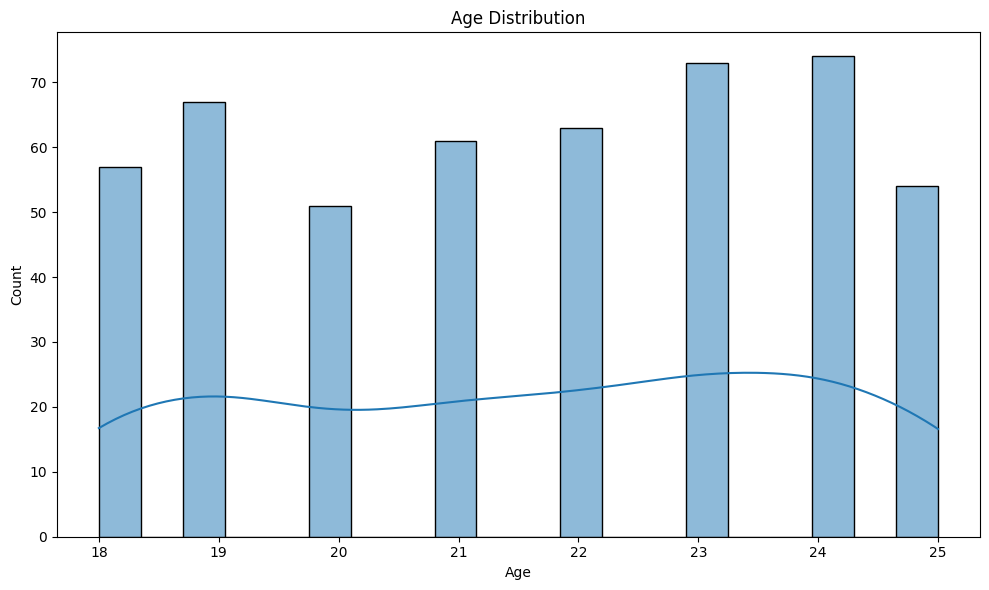

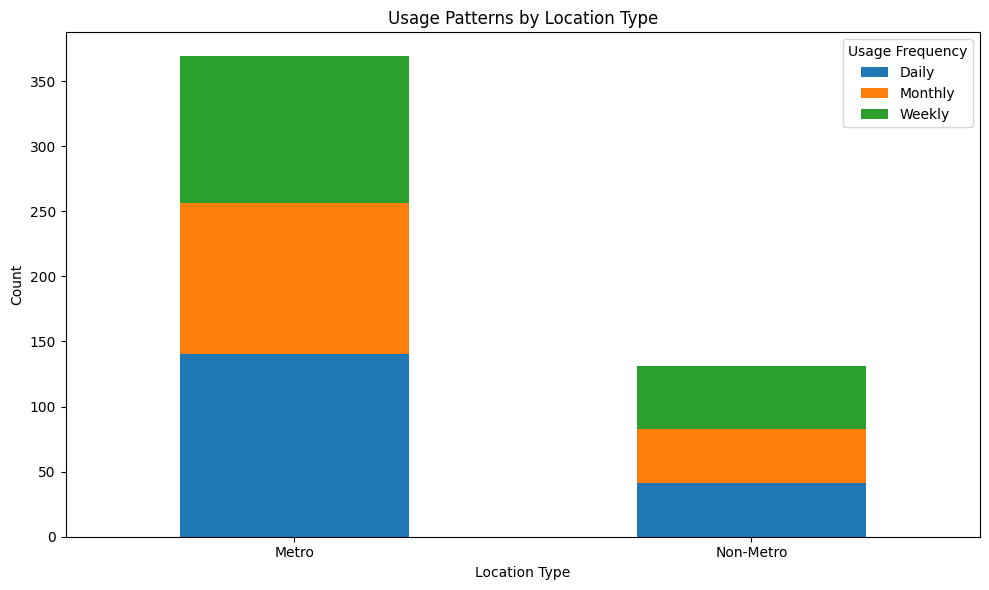

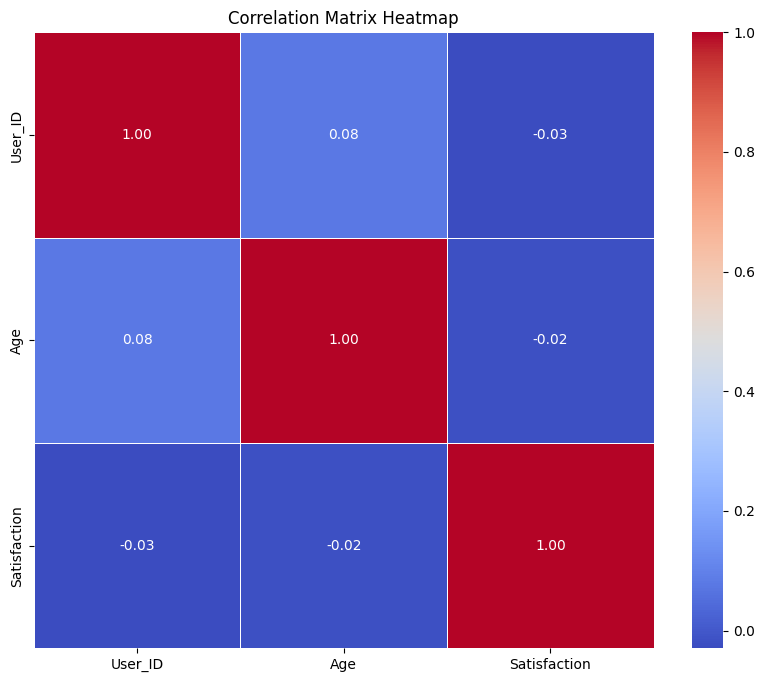

In [18]:

# Exploratory Data Analysis (EDA)
def perform_eda(df):

    plt.figure(figsize=(12, 8))
    
    # Age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Age', bins=20, kde=True)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Usage patterns by location type
    df['Location_Type'] = df['Location'].apply(
        lambda x: 'Metro' if x in ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata'] else 'Non-Metro'
    )
    location_usage = pd.crosstab(df['Location_Type'], df['Usage_Frequency'])
    location_usage.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Usage Patterns by Location Type')
    plt.xlabel('Location Type')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title="Usage Frequency")
    plt.tight_layout()
    plt.show()

perform_eda(cleaned_df)


# Correlation Matrix & Heatmap
def correlation_analysis(df):
    # Select only numerical columns for correlation
    numeric_df = df.select_dtypes(include=['number'])

    # Check if there are numerical columns to plot
    if numeric_df.shape[1] == 0:
        print("No numerical columns found for correlation analysis.")
        return
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

correlation_analysis(cleaned_df)



# Pivot Tables & Groupby Aggregations
def summarize_data(df):
    # Ensure Satisfaction is numeric (convert errors to NaN)
    df['Satisfaction'] = pd.to_numeric(df['Satisfaction'], errors='coerce')

    # Pivot Table - Average Daily Usage by Gender and Age Group
    df['Age_Group'] = pd.cut(df['Age'], bins=[17, 20, 23, 26], labels=['18-20', '21-23', '24-26'])
    pivot_table = df.pivot_table(values='Daily_Usage_Time', index='Gender', columns='Age_Group', aggfunc='mean')
    print("\nPivot Table: Average Daily Usage Time by Gender and Age Group")
    print(pivot_table)

    # Groupby Aggregation - Satisfaction by Location
    location_satisfaction = df.groupby('Location_Type')['Satisfaction'].mean()
    print("\nAverage Satisfaction by Location Type:")
    print(location_satisfaction)

    summarize_data(cleaned_df)




Gender Distribution (%):
Gender
female        35.2
male          34.2
non-binary    30.6
Name: proportion, dtype: float64

Age Group Distribution (%):
Age_Group
21-23    39.4
18-20    35.0
24-26    25.6
Name: proportion, dtype: float64

Location Type Distribution (%):
Location_Type
Metro        73.8
Non-Metro    26.2
Name: proportion, dtype: float64

Potential Biases:
Location bias detected: One location type is overrepresented.


<Figure size 1200x800 with 0 Axes>

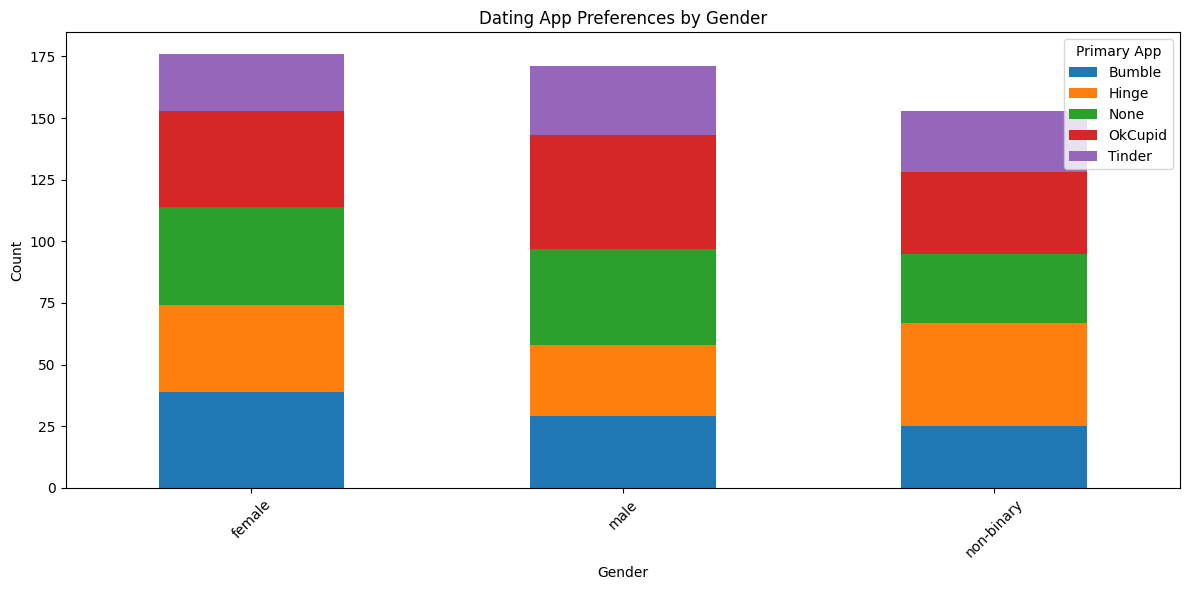

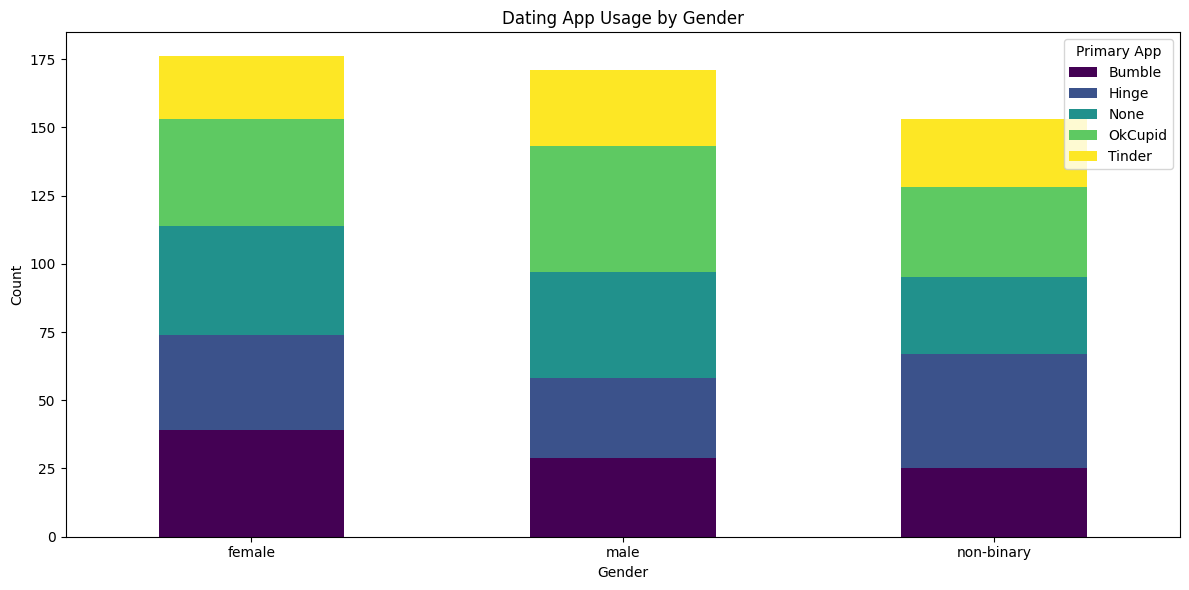

In [24]:
# Bias Analysis - Identify Overrepresented and Underrepresented Groups
def analyze_bias(df):
    # Gender distribution
    gender_dist = df['Gender'].value_counts(normalize=True) * 100
    print("Gender Distribution (%):")
    print(gender_dist)
    
    # Age group distribution
    df['Age_Group'] = pd.cut(df['Age'], bins=[17, 20, 23, 26], labels=['18-20', '21-23', '24-26'])
    age_dist = df['Age_Group'].value_counts(normalize=True) * 100
    print("\nAge Group Distribution (%):")
    print(age_dist)
    
    # Location distribution
    location_dist = df['Location_Type'].value_counts(normalize=True) * 100
    print("\nLocation Type Distribution (%):")
    print(location_dist)
    
    # Identify overrepresented/underrepresented groups
    print("\nPotential Biases:")
    if gender_dist.max() > 60:
        print("Gender bias detected: One gender is overrepresented.")
    if age_dist.max() > 60:
        print("Age group bias detected: One age group is overrepresented.")
    if location_dist.max() > 60:
        print("Location bias detected: One location type is overrepresented.")

    # Dating app preferences by gender - Stacked Bar Chart
    plt.figure(figsize=(12, 8))
    app_by_gender = pd.crosstab(df['Gender'], df['Primary_App'])
    app_by_gender.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Dating App Preferences by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title="Primary App")
    plt.tight_layout()
    plt.show()

    # Stacked Bar Chart - Dating App Usage by Gender
    def stacked_bar_chart(df):
     app_by_gender = pd.crosstab(df['Gender'], df['Primary_App'])
     app_by_gender.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
     plt.title('Dating App Usage by Gender')
     plt.xlabel('Gender')
     plt.ylabel('Count')
     plt.legend(title="Primary App")
     plt.xticks(rotation=0)
     plt.tight_layout()
     plt.show()

    stacked_bar_chart(cleaned_df)
    
analyze_bias(cleaned_df)



    


